<a href="https://colab.research.google.com/github/smallrus-web/AZSII_prz3/blob/main/%D0%90%D1%80%D1%85%D0%B8%D0%BF%D0%BE%D0%B2_%D0%94%D0%BC%D0%B8%D1%82%D1%80%D0%B8%D0%B9_prz3_ipynb%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Группа: ББМО-01-23

Студент: Архипов Дмитрий Евгеньевич

Практика 3: Атака Carlini-Wagner (CW) на модели
ИИ




**1. Загрузка обученной модели и данных MNIST**


In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0

# Преобразование меток в формат one-hot encoding
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9733 - loss: 0.0970
Test accuracy on clean images: 0.9768000245094299


**2. Установка Foolbox и запуск CW-атаки**

In [3]:
pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.0 MB/s eta 0:00:00


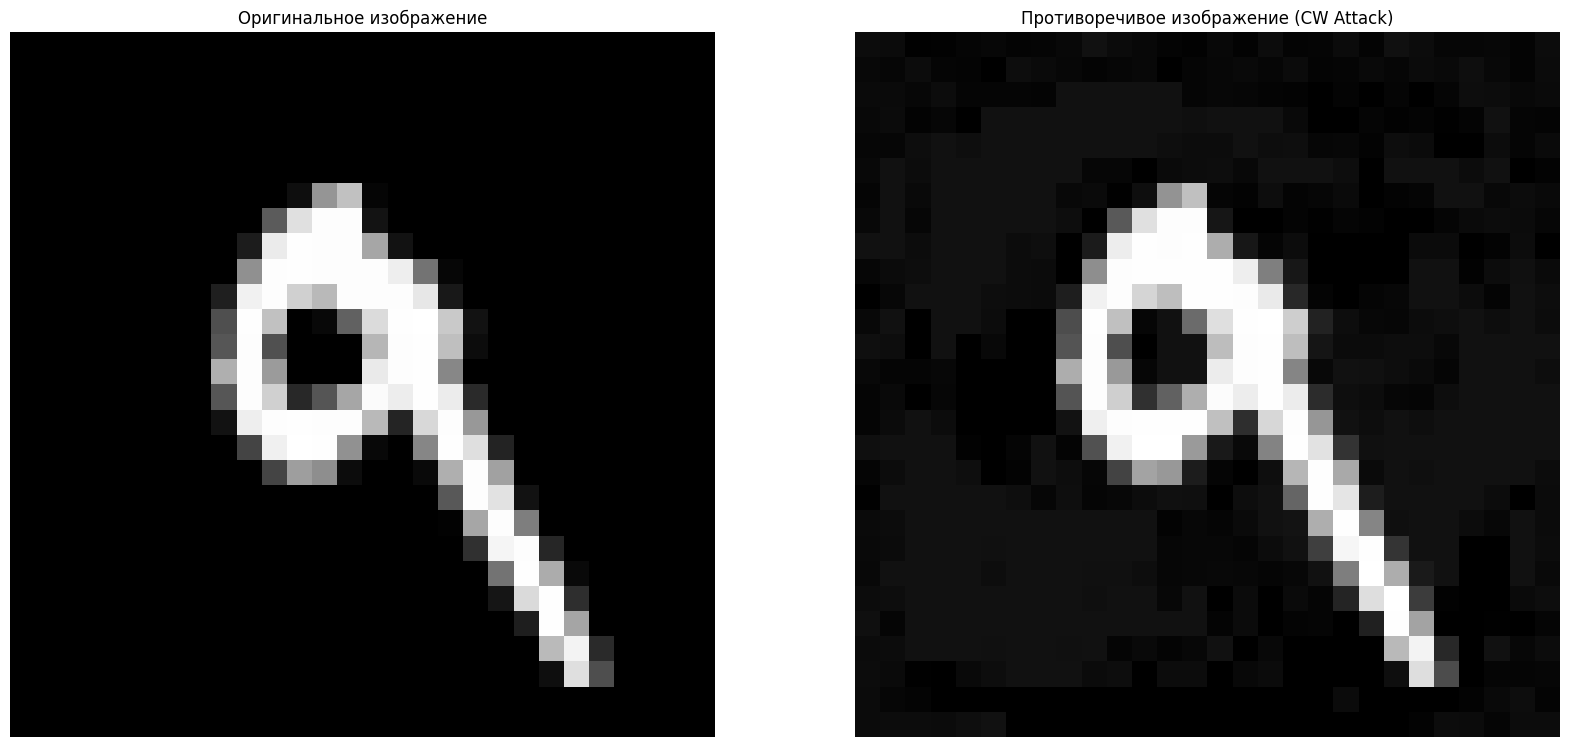

In [20]:
import foolbox as fb
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Преобразование меток в обычные классы (из one-hot в нормальные метки)
test_labels_classes = np.argmax(test_labels, axis=1)

# Найти индекс изображения, которое соответствует цифре 9
index_of_9 = np.where(test_labels_classes == 9)[0][0]  # Ищем первое вхождение цифры 9

# Инициализация Foolbox модели:
fmodel = fb.TensorFlowModel(model, bounds=(-1, 1))

# Выбор изображения для атаки (например, изображение с цифрой 9):
# Добавление размерности для батча:
image = tf.convert_to_tensor(test_images[index_of_9], dtype=tf.float32)[None, ...]
# Получение индекса класса:
label = 9  # Мы знаем, что это цифра 9
# Преобразование в тензор:
label = tf.convert_to_tensor(label, dtype=tf.int64)

# Создание атаки Carlini-Wagner:
attack = fb.attacks.L2CarliniWagnerAttack(steps=10)
# Выполнение атаки:
adversarial_image, _, success = attack(fmodel, image, label[None], epsilons=0.01)

# Вывод результатов:
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Противоречивое изображение (CW Attack)")
plt.imshow(adversarial_image[0].numpy(), cmap="gray")
plt.axis('off')

plt.show()

**3. Оценка модели на противоречивых примерах**

In [24]:
# Создание набора противоречивых примеров для всего тестового набора
adversarial_images = []
for i in range(len(test_images) // 10): # ограничил выборку для ускорения выполнения
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.1)
    adversarial_images.append(advs)

# Оценка точности модели на противоречивых примерах
adversarial_images = tf.concat(adversarial_images, axis=0)
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels[:1000])
print(f'Accuracy on adversarial examples (CW attack): {adversarial_acc}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0924 - loss: 2.3513 
Accuracy on adversarial examples (CW attack): 0.08399999886751175


**4. Вывод**

Точность модели после проведения атаки: 0.084 (8.4%)

Это означает, что точность модели на атакованных изображениях значительно снизилась по сравнению с исходной точностью (98%). Точность на атакованных примерах составляет всего 8.4%, что говорит о сильной уязвимости модели к атаке Carlini-Wagner.

Потери модели: 2.3513

Увеличение значения функции потерь также указывает на существенное ухудшение работы модели. Атака Carlini-Wagner привела к значительному искажениям входных данных, что снизило способность модели правильно классифицировать изображения, несмотря на минимальные изменения в самих изображениях.